# Assessing VTE in cancer patients using deep learning synthetic data generation and domain adaptation techniques.

This notebook contains all the code to reproduce the third experiment of the thesis.

In [28]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sdv.tabular import CopulaGAN, CTGAN,TVAE
from sklearn.metrics import roc_auc_score, confusion_matrix, precision_score, ConfusionMatrixDisplay

In [29]:
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

In [30]:
df_alleles = pd.read_csv('oncoth1_with_n_risk_alleles.csv')

In [31]:
df = pd.read_csv('development_db_score_oncothromb.csv')

In [32]:
df_alleles['VTE'] = df['VTE'].values

# Apply paper preprocess pipeline

The paper selects the following variables: 
- rs4524
- rs6025
- rs2232698
- rs2227631
- rs268
- rs169713
- rs11696364
- rs5110
- rs6003

In [33]:
gen_predictors = ['rs4524', 'rs6025', 'rs2232698', 'rs2227631', 'rs268', 'rs169713', 'rs11696364', 'rs5110','rs6003']

In [34]:
#Select the risk alleles of the selected features
alleles_ = []
for element in gen_predictors:
    alleles_.append(element + '_n_risk_alleles')
alleles_.append('VTE')
alleles_.append('id')
df_alleles = df_alleles[alleles_].dropna()

### Compute Genetic Risk Score

In [35]:
from sklearn.linear_model import LogisticRegression

y = df_alleles['VTE']
X = df_alleles.drop(columns=['VTE', 'id'])

model = LogisticRegression(fit_intercept = True)
model.fit(X, y)

GRS = (model.coef_ * X).sum(axis=1) + model.intercept_
df_alleles['GRS'] = GRS

## Clinical Variables

- very high risk -> stomach, pancreas
- high risk -> lung, lymphoma, gynelocoligal, blader, testicular
- low risk -> colorectal
- platelet count >= 350x10^9/L -> high risk
- leukocyte count >= 11x10^9/L -> high risk

In [36]:
import re
def map_column(row, clinical_dict):
    row = str(row)
    for key, value in clinical_dict.items():
        if re.match(value[0], row):
            return key
    return 'No Clasificado'

In [37]:
def preprocess_clinical_features(df):
    df_clin = df.iloc[:, 1:21]
    cols_names_clin = df_clin.columns[1:]

    df_clin.loc[df_clin['primary_tumor_simplified'] == 'Colorectal', 'primary_tumor_simplified'] = 0
    df_clin.loc[df_clin['primary_tumor_simplified'] == 'NSCLC', 'primary_tumor_simplified'] = 1
    df_clin.loc[df_clin['primary_tumor_simplified'] == 'Oesophago-gastric', 'primary_tumor_simplified'] = 2
    df_clin.loc[df_clin['primary_tumor_simplified'] == 'Pancreatic', 'primary_tumor_simplified'] = 2

    df_clin.loc[df_clin['leukocytes'] < 11000, 'leukocytes'] = 0
    df_clin.loc[df_clin['leukocytes'] >= 11000, 'leukocytes'] = 1
    df_clin.loc[df_clin['platelets'] < 350000, 'platelets'] = 0
    df_clin.loc[df_clin['platelets'] >= 350000, 'platelets'] = 1

    bmi_risk = {
        1: [r"(Obese: BMI > 30 kg/m2)|( Overweight: BMI ~25-29.9 Kg/m2)"],
        0: [r"(Normal: BMI ~ 18.5-24.9 Kg/m2)|(Underweight: BMI < 18.5 Kg/m2)"],
    }

    tnm_stage_detailed_risk = {
        1: [r"(IA)|(IB)"],
        2: [r"(IIB)|(IIA)|(IIC)"],
        3: [r"(III)|(IIIB)|(IIIA)|(IIIC)"],
        4: [r"(IVB)|(IVA)|(IV)"],
    }


    df_clin['bmi_category'] = df_clin['bmi_category'].apply(lambda x: map_column(x, bmi_risk))
    df_clin['tnm_stage_detailed'] = df_clin['tnm_stage_detailed'].apply(lambda x: map_column(x, tnm_stage_detailed_risk))

    return df_clin

In [38]:
df_clin = preprocess_clinical_features(df)

### Get the clinical variables following the paper (without p-value selection )

In [39]:
# Drop the variables that are not mentioned in the paper
df_clin = df_clin.drop(['pregnancy', 'oral_contraceptives', 'hemoglobin'], axis=1)
df_clin['id'] = df['id'].values

Select the predictors of the paper

In [40]:
clin_predictors = ['tnm_stage_detailed', 'bmi_category', 'primary_tumor_simplified', 'id', 'VTE']
df_clin = df_clin[clin_predictors]

pred = ['id', 'GRS', 'VTE']
predictors = df_alleles[pred]

df_ft = predictors.merge(df_clin, on=['id','VTE'])

df = df_ft.drop(['id'],axis=1)

df['primary_tumor_simplified'] = df['primary_tumor_simplified'].astype(int)

In [41]:
df.head()

,GRS,VTE,tnm_stage_detailed,bmi_category,primary_tumor_simplified
0,-0.309952,1,4,1,2
1,-1.015882,0,2,0,2
2,-0.994715,0,3,1,2
3,-2.016533,0,2,0,2
4,-1.283673,0,1,0,2


In [42]:
X_real_dupes = df.drop('VTE', axis=1)
y_real_dupes = df['VTE']

In [43]:
df_no_dupes = df.drop_duplicates()

In [44]:
X_real_no_dupes = df_no_dupes.drop('VTE', axis=1)
y_real_no_dupes = df_no_dupes['VTE']

# Generate Data

In [52]:
model = CopulaGAN.load('best_CopulaGAN.pkl')

C:\Users\SergiBech\anaconda3\envs\sdv\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator BayesianGaussianMixture from version 1.1.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\SergiBech\anaconda3\envs\sdv\lib\site-packages\sdv\utils.py:113: UserWarning: The libraries used to create the model have older versions than your current setup. This may cause errors when sampling.
rdt used version `1.3.0`; current version is `1.5.0`
ctgan used version `0.7.1`; current version is `0.7.3`
  warnings.warn(f'{warning_str}{mismatched_details}')


In [53]:
synth_gen = model.sample(num_rows=150000)

In [54]:
from sdv.evaluation import evaluate
print(evaluate(synth_gen, df))

0.9674212225300092


In [55]:
import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(synth_gen.drop('VTE', axis=1), synth_gen['VTE'], test_size=0.2, random_state=42)

# Scale the features using StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

clf = LogisticRegression()
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.8420666666666666

In [56]:
y_pred = clf.predict(X_test)
auc_obs = roc_auc_score(y_test, y_pred)
print(auc_obs)

0.6513616671907208


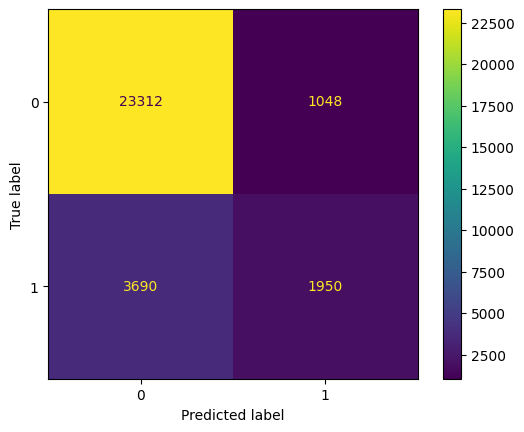

In [57]:
# Compute confusion matrix
cm = confusion_matrix(y_test.values, np.round(y_pred))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
disp.plot()
plt.show()

In [58]:
#Load data form baselines curves
roc_curve_onco = pd.read_csv('no_dups_roc_curve_oncothromb_score_replicated.csv')
pr_curve_onco = pd.read_csv('no_dups_pr_curve_oncothromb_score_replicated.csv')
roc_curve_orig = pd.read_csv('mean_roc_curve_from_cv_oncothromb.csv')
prc_curve_orig = pd.read_csv('pr_curve_oncothromb_score_replicated.csv')

C:\Users\SergiBech\anaconda3\envs\sdv\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\SergiBech\anaconda3\envs\sdv\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


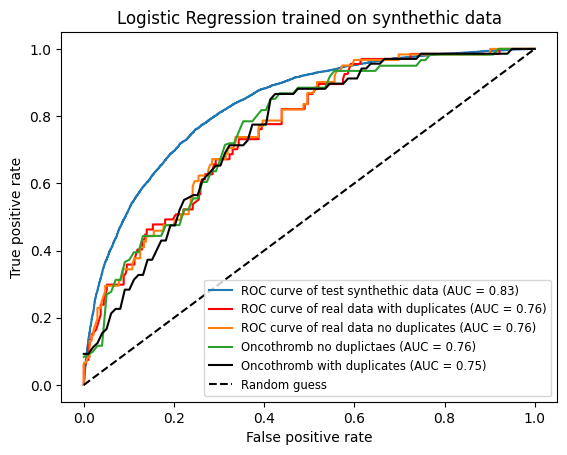

In [59]:
from sklearn.metrics import roc_curve, auc

# Calculate the false positive rate, true positive rate, and threshold values for the ROC curve
fpr, tpr, thresholds = roc_curve(y_test,clf.predict_proba(X_test)[:,1])
#fpr_2, tpr_2, thresholds_2 = roc_curve(y_points,pred_points)
fpr_3, tpr_3, thresholds_3 = roc_curve(y_real_dupes,clf.predict_proba(X_real_dupes)[:,1])
fpr_4, tpr_4, thresholds_4 = roc_curve(y_real_no_dupes,clf.predict_proba(X_real_no_dupes)[:,1])


# Calculate the AUC value
auc_value = auc(fpr, tpr)
auc_value_2 = auc(fpr_3, tpr_3)
auc_value_5 = auc(fpr_4, tpr_4)
auc_value_3 = auc(roc_curve_onco['fpr_points'], roc_curve_onco['mean_tpr'])
auc_value_4 = auc(roc_curve_orig['fpr_points'], roc_curve_orig['mean_tpr'])


# Plot the ROC curve and add the AUC value to the plot
plt.plot(fpr, tpr, label='ROC curve of test synthethic data (AUC = %0.2f)' % auc_value)
plt.plot(fpr_3, tpr_3, color='red',label='ROC curve of real data with duplicates (AUC = %0.2f)' % auc_value_2)
plt.plot(fpr_4, tpr_4,label='ROC curve of real data no duplicates (AUC = %0.2f)' % auc_value_5)
plt.plot(roc_curve_onco['fpr_points'], roc_curve_onco['mean_tpr'], label='Oncothromb no duplictaes (AUC = %0.2f)' % auc_value_3)
plt.plot(roc_curve_orig['fpr_points'], roc_curve_orig['mean_tpr'],color='black', label='Oncothromb with duplicates (AUC = %0.2f)' % auc_value_4)

plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Logistic Regression trained on synthethic data')
plt.legend(loc='lower right', fontsize='small')
# Save figure with higher DPI
#plt.savefig('ROC_curve.png', dpi=300)
plt.show()



C:\Users\SergiBech\anaconda3\envs\sdv\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\SergiBech\anaconda3\envs\sdv\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


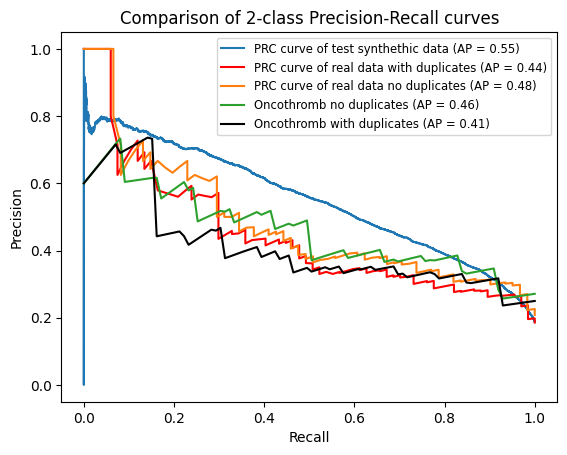

In [60]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Get precision, recall, and threshold values for test data
precision2, recall2, threshold2 = precision_recall_curve(y_test, clf.predict_proba(X_test)[:, 1])

# Get precision, recall, and threshold values for real data
precision3, recall3, threshold3 = precision_recall_curve(y_real_dupes, clf.predict_proba(X_real_dupes)[:, 1])
precision4, recall4, threshold4 = precision_recall_curve(y_real_no_dupes, clf.predict_proba(X_real_no_dupes)[:, 1])


# Create a new figure and axis object
fig, ax = plt.subplots()

ap = auc(pr_curve_onco.recall_points, pr_curve_onco.mean_precision)
ap_2 = auc(recall2, precision2)
ap_3 = auc(recall3, precision3)
ap_5 = auc(recall4, precision4)
ap_4 = auc(prc_curve_orig.recall, prc_curve_orig.precision)


# Plot the test data Precision-Recall curve
ax.plot(recall2, precision2, label='PRC curve of test synthethic data (AP = %0.2f)' % ap_2)

# Plot the real data Precision-Recall curve
ax.plot(recall3, precision3, color='red', label='PRC curve of real data with duplicates (AP = %0.2f)' % ap_3)
ax.plot(recall4, precision4,  label='PRC curve of real data no duplicates (AP = %0.2f)' % ap_5)


# Plot the synthethic data Precision-Recall curve
ax.plot(pr_curve_onco.recall_points, pr_curve_onco.mean_precision, label='Oncothromb no duplicates (AP = %0.2f)' % ap)

ax.plot(prc_curve_orig.recall, prc_curve_orig.precision,color='black', label='Oncothromb with duplicates (AP = %0.2f)' % ap_4)

# Set the x and y axis labels, title, and legend
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.set_title("Comparison of 2-class Precision-Recall curves")
plt.legend(loc='best', fontsize='small')

# Save the figure and show it
#plt.savefig('PRC_curve.png', dpi=300)
plt.show()


# Train a Deep Learning Model with Synthethic Data

In [61]:
import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(synth_gen.drop('VTE', axis=1), synth_gen['VTE'], test_size=0.2, random_state=42)

# Scale the features using StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

def make_model(metrics=METRICS):

    # Define the MLP model with skip connections and dropout
    inputs = keras.layers.Input(shape=(X_train.shape[1],))
    
    x = keras.layers.Dense(units=128, activation='relu')(inputs)
    x = keras.layers.Dropout(0.2)(x)
    
    x = keras.layers.Dense(units=64, activation='relu')(x)
    x = keras.layers.Dropout(0.1)(x)
    
   
    x = keras.layers.Dense(units=16, activation='relu')(x)
    
    outputs = keras.layers.Dense(1, activation = 'sigmoid')(x)
    
    
    model = keras.Model(inputs=inputs, outputs=outputs)

    # Compile the model with the specified optimizer, loss function, and metrics
    model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-3),
      loss= keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=metrics)

    return model

In [62]:
EPOCHS = 100
BATCH_SIZE = 32

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=8,
    mode='max',
    restore_best_weights=True)

In [63]:
del model

In [64]:
from tensorflow.keras.optimizers.schedules import InverseTimeDecay

model = make_model(metrics=METRICS)
baseline_history = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping],
    epochs=EPOCHS,
    validation_data=(X_test, y_test))

Epoch 1/100
3750/3750 [==============================] - 14s 3ms/step - loss: 0.3690 - tp: 8267.0000 - fp: 4617.0000 - tn: 92182.0000 - fn: 14934.0000 - accuracy: 0.8371 - precision: 0.6416 - recall: 0.3563 - auc: 0.8342 - prc: 0.5572 - val_loss: 0.3583 - val_tp: 2231.0000 - val_fp: 1350.0000 - val_tn: 23010.0000 - val_fn: 3409.0000 - val_accuracy: 0.8414 - val_precision: 0.6230 - val_recall: 0.3956 - val_auc: 0.8424 - val_prc: 0.5643
Epoch 2/100
3750/3750 [==============================] - 11s 3ms/step - loss: 0.3633 - tp: 8468.0000 - fp: 4602.0000 - tn: 92197.0000 - fn: 14733.0000 - accuracy: 0.8389 - precision: 0.6479 - recall: 0.3650 - auc: 0.8403 - prc: 0.5682 - val_loss: 0.3565 - val_tp: 1891.0000 - val_fp: 946.0000 - val_tn: 23414.0000 - val_fn: 3749.0000 - val_accuracy: 0.8435 - val_precision: 0.6665 - val_recall: 0.3353 - val_auc: 0.8430 - val_prc: 0.5658
Epoch 3/100
3750/3750 [==============================] - 11s 3ms/step - loss: 0.3623 - tp: 8631.0000 - fp: 4638.0000 - tn: 

10/10 [==============================] - 0s 1ms/step


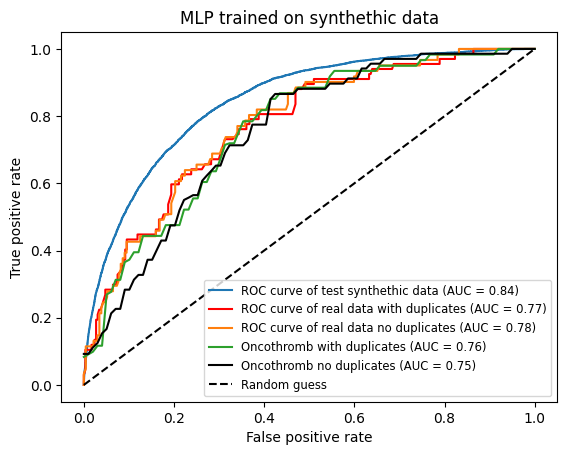

In [65]:
# Calculate the false positive rate, true positive rate, and threshold values for the ROC curve
fpr, tpr, thresholds = roc_curve(y_test,model.predict(X_test))
fpr_3, tpr_3, thresholds_3 = roc_curve(y_real_dupes,model.predict(X_real_dupes))
fpr_4, tpr_4, thresholds_4 = roc_curve(y_real_no_dupes,model.predict(X_real_no_dupes))


# Calculate the AUC value
auc_value = auc(fpr, tpr)
auc_value_2 = auc(fpr_3, tpr_3)
auc_value_5 = auc(fpr_4, tpr_4)
auc_value_3 = auc(roc_curve_onco['fpr_points'], roc_curve_onco['mean_tpr'])
auc_value_4 = auc(roc_curve_orig['fpr_points'], roc_curve_orig['mean_tpr'])


# Plot the ROC curve and add the AUC value to the plot
plt.plot(fpr, tpr, label='ROC curve of test synthethic data (AUC = %0.2f)' % auc_value)
plt.plot(fpr_3, tpr_3,color='red', label='ROC curve of real data with duplicates (AUC = %0.2f)' % auc_value_2)
plt.plot(fpr_4, tpr_4, label='ROC curve of real data no duplicates (AUC = %0.2f)' % auc_value_5)

plt.plot(roc_curve_onco['fpr_points'], roc_curve_onco['mean_tpr'], label='Oncothromb with duplicates (AUC = %0.2f)' % auc_value_3)
plt.plot(roc_curve_orig['fpr_points'], roc_curve_orig['mean_tpr'], color='black',label='Oncothromb no duplicates (AUC = %0.2f)' % auc_value_4)

plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('MLP trained on synthethic data')
plt.legend(loc='best', fontsize='small')

# Save figure with higher DPI
#plt.savefig('ROC_curve_MLP.png', dpi=300)
plt.show()

10/10 [==============================] - 0s 1ms/step


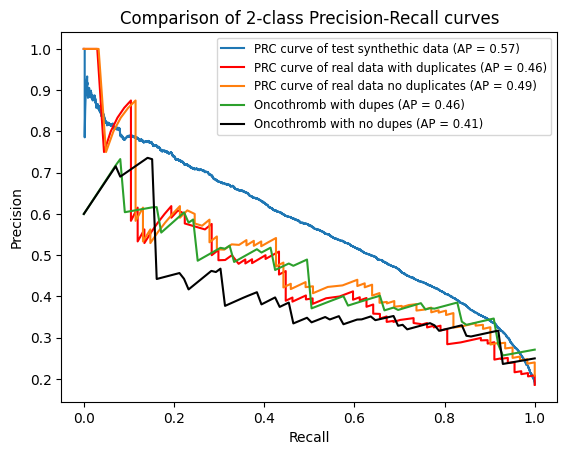

In [66]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Get precision, recall, and threshold values for test data
precision2, recall2, threshold2 = precision_recall_curve(y_test, model.predict(X_test))

# Get precision, recall, and threshold values for real data
precision3, recall3, threshold3 = precision_recall_curve(y_real_dupes, model.predict(X_real_dupes))
precision4, recall4, threshold4 = precision_recall_curve(y_real_no_dupes, model.predict(X_real_no_dupes))


# Create a new figure and axis object
fig, ax = plt.subplots()

ap = auc(pr_curve_onco.recall_points, pr_curve_onco.mean_precision)
ap_4 = auc(prc_curve_orig.recall, prc_curve_orig.precision)
ap_2 = auc(recall2, precision2)
ap_3 = auc(recall3, precision3)
ap_5 = auc(recall4, precision4)

# Plot the test data Precision-Recall curve
ax.plot(recall2, precision2, label='PRC curve of test synthethic data (AP = %0.2f)' % ap_2)

# Plot the real data Precision-Recall curve
ax.plot(recall3, precision3, color='red', label='PRC curve of real data with duplicates (AP = %0.2f)' % ap_3)
ax.plot(recall4, precision4, label='PRC curve of real data no duplicates (AP = %0.2f)' % ap_5)


# Plot the synthethic data Precision-Recall curve
ax.plot(pr_curve_onco.recall_points, pr_curve_onco.mean_precision, label='Oncothromb with dupes (AP = %0.2f)' % ap)

ax.plot(prc_curve_orig.recall, prc_curve_orig.precision,color='black', label='Oncothromb with no dupes (AP = %0.2f)' % ap_4)


# Set the x and y axis labels, title, and legend
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.set_title("Comparison of 2-class Precision-Recall curves")
plt.legend(loc='best', fontsize='small')

# Save the figure and show it
#plt.savefig('PRC_curve_MLP.png', dpi=300)
plt.show()

# Fine-Tune the Model

In [67]:
neg, pos = np.bincount(df['VTE'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 361
    Positive: 67 (18.56% of total)



In [68]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.61
Weight for class 1: 2.69


In [69]:
pretrained_model = keras.models.clone_model(model)

# 5 fold cv

In [88]:
class_weight = {0: 0.61, 1:2.69}

In [89]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve, auc, average_precision_score

In [90]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=5,
    mode='max',
    restore_best_weights=True)

In [91]:
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True)

In [92]:
fprs = []
tprs = []
aucs = []
precisions = []
recalls = []
aps = []

In [93]:
#import results
#recalls_2 = np.load('recalls_dupes.npy', allow_pickle=True)
#precisions_2 = np.load('precisions_dupes.npy', allow_pickle=True)
#aps_2 = np.load('aps_dupes.npy', allow_pickle=True)
#fprs_2 = np.load('fprs_dupes.npy', allow_pickle=True)
#tprs_2 = np.load('tprs_dupes.npy', allow_pickle=True)
#aucs_2 = np.load('aucs_dupes.npy', allow_pickle=True)

In [108]:
X_train = df.drop(['VTE'], axis=1).reset_index(drop=True)
y_train = df['VTE'].reset_index(drop=True)

In [109]:
#No duplicates
#X_train = df_no_dupes.drop(['VTE'], axis=1).reset_index(drop=True)
#y_train = df_no_dupes['VTE'].reset_index(drop=True)

In [110]:
for i, (train_index, test_index) in enumerate(skf.split(X_train, y_train)):
    
    # Get the training and validation data for this fold
    X_train_fold = X_train.iloc[train_index]
    y_train_fold = y_train[train_index]
    X_val_fold = X_train.iloc[test_index]
    y_val_fold = y_train.iloc[test_index]
    
    pretrained_model = keras.models.clone_model(model)
    
    # Get the output of the second-to-last layer in the model
    second_to_last_layer = pretrained_model.layers[-2].output
    # Get the output layer of the pretrained model
    output_layer = pretrained_model.layers[-1].activation
    ## Add a new Dense layer with 8 units and 'relu' activation
   # new_layer = keras.layers.Dense(8, activation='relu')(second_to_last_layer)
   # new_layer = keras.layers.Dense(16, activation='relu')(new_layer)

    # Create a new model that includes both the new layer and the output layer of the pretrained model
    #new_output = keras.layers.Dense(1, activation=output_layer)(new_layer)
    outputs = keras.layers.Dense(1, activation = 'sigmoid')(second_to_last_layer)
    # Create a new model that includes the new layer
    new_model = keras.models.Model(inputs=pretrained_model.input, outputs=outputs)

    # Freeze the weights of all layers except the new layer
    for layer in new_model.layers[:-2]:
        layer.trainable = True
    # Compile the model with the specified optimizer, loss function, and metrics
    new_model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3), # Use a smaller learning rate for fine-tuning
        loss=keras.losses.BinaryCrossentropy(from_logits=False),
        metrics=METRICS)
    
        # Train the model on your real data
    pre_trained_history = new_model.fit(
        X_train_fold, y_train_fold,
        batch_size=16,
        epochs=25,
        class_weight= class_weight,
        callbacks = [early_stopping],
        validation_data=(X_val_fold, y_val_fold))

    # Save the fine-tuned model
    #pretrained_model.save('fine_tuned_model.h5'
    
    fpr, tpr, thresholds = roc_curve(y_val_fold,new_model.predict(X_val_fold))
    fprs.append(fpr)
    tprs.append(tpr)
    precision, recall, thresholds = precision_recall_curve(y_val_fold, new_model.predict(X_val_fold))
    precisions.append(precision)
    recalls.append(recall)
    # Compute the AUC for this fold
    auc_val = roc_auc_score(y_val_fold, new_model.predict(X_val_fold))
    aucs.append(auc_val)
    # Compute the AP for this fold
    ap = average_precision_score(y_val_fold, new_model.predict(X_val_fold))   
    aps.append(ap)
    if i != 4:
        del new_model


Epoch 1/25
18/18 [==============================] - 2s 43ms/step - loss: 0.6867 - tp: 29.0000 - fp: 101.0000 - tn: 193.0000 - fn: 37.0000 - accuracy: 0.6167 - precision: 0.2231 - recall: 0.4394 - auc: 0.5870 - prc: 0.2603 - val_loss: 0.6832 - val_tp: 10.0000 - val_fp: 25.0000 - val_tn: 34.0000 - val_fn: 4.0000 - val_accuracy: 0.6027 - val_precision: 0.2857 - val_recall: 0.7143 - val_auc: 0.7161 - val_prc: 0.5357
Epoch 2/25
18/18 [==============================] - 0s 7ms/step - loss: 0.6701 - tp: 38.0000 - fp: 104.0000 - tn: 131.0000 - fn: 15.0000 - accuracy: 0.5868 - precision: 0.2676 - recall: 0.7170 - auc: 0.6489 - prc: 0.2986 - val_loss: 0.6694 - val_tp: 10.0000 - val_fp: 24.0000 - val_tn: 35.0000 - val_fn: 4.0000 - val_accuracy: 0.6164 - val_precision: 0.2941 - val_recall: 0.7143 - val_auc: 0.7149 - val_prc: 0.5364
Epoch 3/25
18/18 [==============================] - 0s 7ms/step - loss: 0.6364 - tp: 38.0000 - fp: 90.0000 - tn: 145.0000 - fn: 15.0000 - accuracy: 0.6354 - precision: 0

Epoch 13/25
19/19 [==============================] - 0s 7ms/step - loss: 0.6009 - tp: 34.0000 - fp: 65.0000 - tn: 171.0000 - fn: 19.0000 - accuracy: 0.7093 - precision: 0.3434 - recall: 0.6415 - auc: 0.7433 - prc: 0.4320 - val_loss: 0.6226 - val_tp: 8.0000 - val_fp: 24.0000 - val_tn: 34.0000 - val_fn: 6.0000 - val_accuracy: 0.5833 - val_precision: 0.2500 - val_recall: 0.5714 - val_auc: 0.7408 - val_prc: 0.4260
Epoch 14/25
19/19 [==============================] - 0s 7ms/step - loss: 0.5971 - tp: 34.0000 - fp: 63.0000 - tn: 173.0000 - fn: 19.0000 - accuracy: 0.7163 - precision: 0.3505 - recall: 0.6415 - auc: 0.7524 - prc: 0.4292 - val_loss: 0.6461 - val_tp: 10.0000 - val_fp: 27.0000 - val_tn: 31.0000 - val_fn: 4.0000 - val_accuracy: 0.5694 - val_precision: 0.2703 - val_recall: 0.7143 - val_auc: 0.7457 - val_prc: 0.4353
Epoch 14: early stopping
3/3 [==============================] - 0s 1ms/step
Epoch 1/25
19/19 [==============================] - 3s 41ms/step - loss: 0.6976 - tp: 16.0000 -

In [111]:
# Determine the common set of FPR values
fpr_common = np.unique(np.concatenate(fprs))

# Interpolate the TPR values at the common set of FPR values for each fold
tprs_interp = []
for i in range(n_splits):
    tprs_interp.append(np.interp(fpr_common, fprs[i], tprs[i]))

# Calculate the mean and standard deviation of the interpolated TPR values and AUCs across all folds
mean_tpr = np.mean(tprs_interp, axis=0)
std_tpr = np.std(tprs_interp, axis=0)

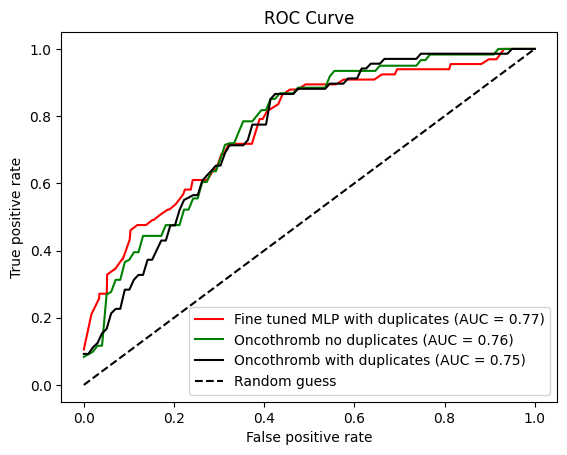

In [112]:
# Calculate the AUC value
auc_value = auc(fpr_common, mean_tpr)
auc_value_3 = auc(roc_curve_onco['fpr_points'], roc_curve_onco['mean_tpr'])
auc_value_4 = auc(roc_curve_orig['fpr_points'], roc_curve_orig['mean_tpr'])
auc_value_2 = auc(fpr_common, mean_tpr)

# Plot the ROC curve
#plt.plot(fpr_common, mean_tpr, color='orange', label='Fine tuned MLP no duplicates (AUC = %0.2f)' % auc_value)

plt.plot(fpr_common, mean_tpr, color='red', label='Fine tuned MLP with duplicates (AUC = %0.2f)' % auc_value)


plt.plot(roc_curve_onco['fpr_points'], roc_curve_onco['mean_tpr'], color='green', label='Oncothromb no duplicates (AUC = %0.2f)' % auc_value_3)

plt.plot(roc_curve_orig['fpr_points'], roc_curve_orig['mean_tpr'], color='black', label='Oncothromb with duplicates (AUC = %0.2f)' % auc_value_4)

plt.plot([0, 1], [0, 1], 'k--', label='Random guess')

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve')
plt.legend(loc='best')

#plt.savefig('ROC_curve_MLP_fine_tuned_final.png', dpi=300)

plt.show()

In [113]:
# Determine the common set of recall values
recall_common = np.unique(np.concatenate(recalls))
# Interpolate the precision values at the common set of recall values for each fold
precisions_interp = []
for i in range(n_splits):
    precisions_interp.append(np.interp(recall_common, recalls[i][::-1], precisions[i][::-1]))
    
# Calculate the mean and standard deviation of the interpolated precision values and AUCs across all folds
mean_precision = np.mean(precisions_interp, axis=0)

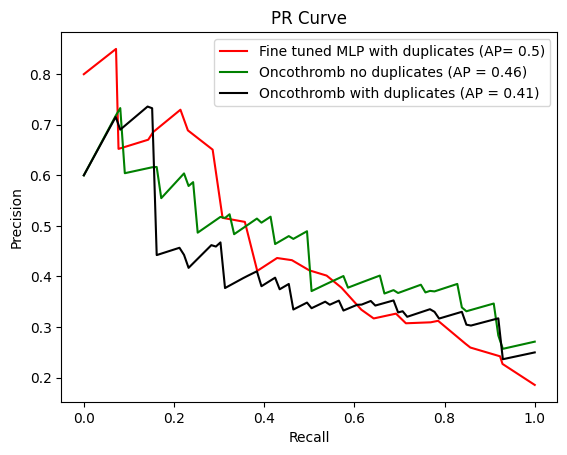

In [114]:
# Plot the mean PR curve with shaded areas representing the standard deviation
plt.plot(recall_common, mean_precision, color='red', label='Fine tuned MLP with duplicates (AP= ' + str(round(np.mean(aps),2)) + ')')

#plt.plot(recall_common, mean_precision, color='red', label='Fine tuned MLP no duplicates (AP= ' + str(round(np.mean(aps),2)) + ')')


# Plot the real data Precision-Recall curve
ap = auc(pr_curve_onco.recall_points, pr_curve_onco.mean_precision)
ap_4 = auc(prc_curve_orig.recall, prc_curve_orig.precision)

plt.plot(pr_curve_onco.recall_points,pr_curve_onco.mean_precision, color='green', label='Oncothromb no duplicates (AP = %0.2f)' % ap)

plt.plot(prc_curve_orig.recall,prc_curve_orig.precision, color='black', label='Oncothromb with duplicates (AP = %0.2f)' % ap_4)

#plt.plot(onco_svm['recall'].values, onco_svm['mean'].values,color='green', label ='SVM')
#plt.plot(onco_rf['recall'].values, onco_rf['precision'].values,color='black', label ='Random Forest')

plt.plot()
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR Curve')
plt.legend()

#plt.savefig('PRC_curve_MLP_fine_tuned_final.png', dpi=300)
plt.show()